In [1]:
import sys
sys.path.append('/Users/ham/Desktop/LSHiforest')
import numpy as np
import pandas as pd
from CLSHiForest import CLSHiForest
from sklearn.metrics import accuracy_score

In [2]:
# NSL-KDD列名（41特徴量 + ラベル）
column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','label', 'difficulty'
]

# 文字列特徴量のみを抽出
#categorical_columns = ['protocol_type', 'service', 'flag']
categorical_columns = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
df_full = pd.read_csv("KDDTrain+.txt", names=column_names)
df_cat = df_full[categorical_columns + ['label']].copy()

# ラベル（normal vs 攻撃）を 0/1 に変換
df_cat['label'] = df_cat['label'].apply(lambda x: 0 if x == 'normal' else 1)

In [3]:
# 正常データと異常データを分離
normal_data = df_cat[df_cat['label'] == 0]
anomaly_data = df_cat[df_cat['label'] == 1]

print(f"正常データ: {len(normal_data)}件")
print(f"異常データ: {len(anomaly_data)}件")

# 正常データを学習用とテスト用に分割（重複なし）
train_size = 0.8  # 学習データの割合
normal_train = normal_data.iloc[:int(normal_data.shape[0]*train_size)]
normal_test = normal_data.drop(normal_train.index)  # 学習データに含まれていない残りのデータ

# トレーニングデータ（正常データのみ）
X_train = normal_train.drop('label', axis=1)
y_train = normal_train['label']  # すべて0

# テストデータ（残りの正常データ + 異常データ）
X_test = pd.concat([normal_test, anomaly_data]).drop('label', axis=1)
y_test = pd.concat([normal_test, anomaly_data])['label']

print(f"トレーニングデータ: {len(X_train)}件 (すべて正常データ)")
print(f"テストデータ: {len(X_test)}件")
print(f" - 正常データ: {sum(y_test == 0)}件")
print(f" - 異常データ: {sum(y_test == 1)}件")

正常データ: 67343件
異常データ: 58630件
トレーニングデータ: 53874件 (すべて正常データ)
テストデータ: 72099件
 - 正常データ: 13469件
 - 異常データ: 58630件


In [4]:
# モデル訓練・評価
model = CLSHiForest(n_trees=100, max_depth=10, hash_dim=10, min_samples=10, random_state=42)
model.fit(X_train)
scores = model.decision_function(X_test)

One-hotEncode後の特徴量数:(53874, 46)


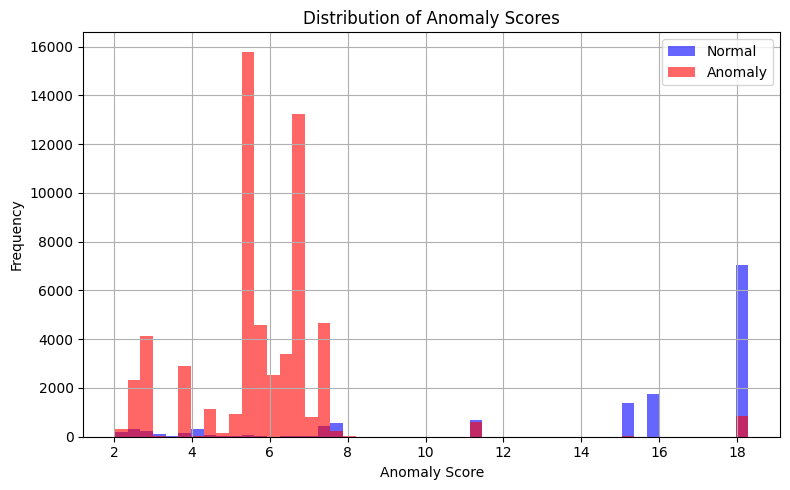

In [5]:
# 異常スコアの分布をプロット
model.plot_score_distribution(scores, y_test)

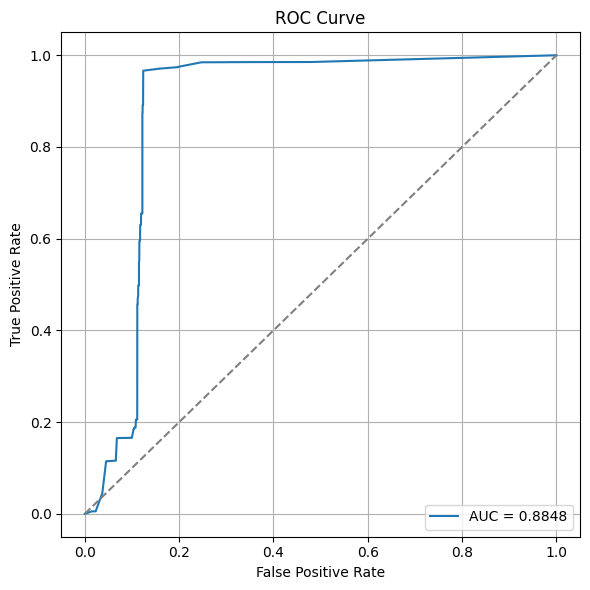

In [6]:
# AUC-ROCを計算
auc = model.plot_roc_curve(scores, y_test)

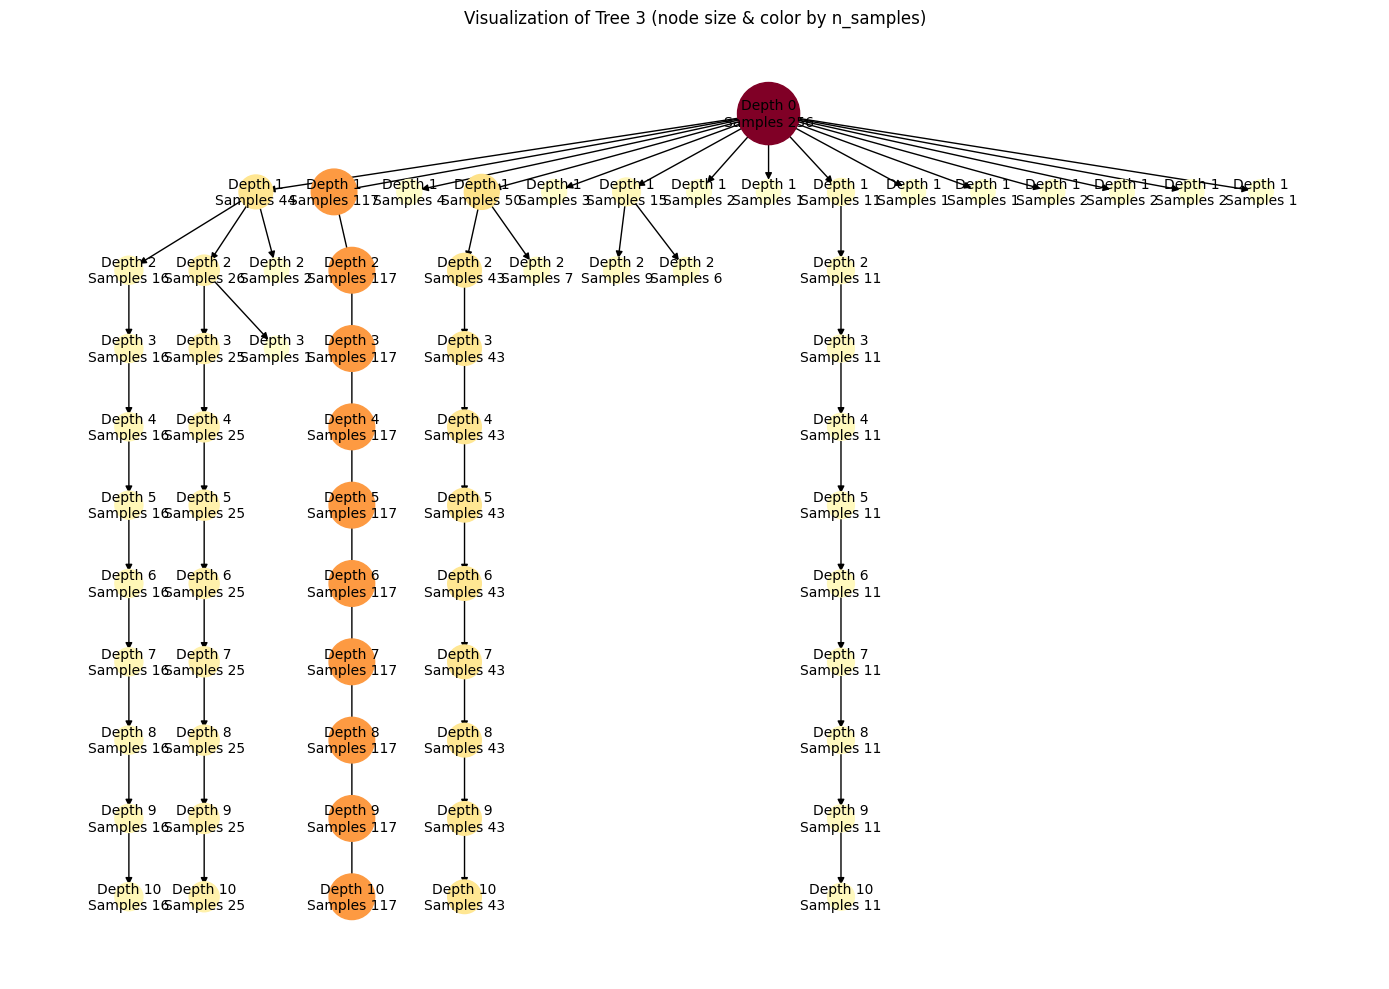

In [7]:
# 最初の木を可視化
model.visualize_tree(tree_index=3)